In [139]:
import os, sys

def get_dir_n_levels_up(path, n):
    # Go up n levels from the given path
    for _ in range(n):
        path = os.path.dirname(path)
    return path

proj_root = get_dir_n_levels_up(os.path.abspath("__file__"), 4)
sys.path.append(proj_root)

import pandas as pd
import yaml
import torch
import collections

import warnings
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

warnings.filterwarnings("ignore")

from dqn.opinion_dynamics.utils.experiment import process_experiment


In [140]:
# experiment_sub_dir = "2025May02-101004_configs" # excellent run
experiment_sub_dir = "2025May09-234645_configs"

exp_path = os.path.join(r"D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dynamics\experiments\results", experiment_sub_dir)
df = process_experiment(
    exp_path
)
df.columns


Index(['epoch_type', 'frame_stamp', 'greedy_epsilon', 'episode_rewards_min',
       'episode_rewards_max', 'episode_rewards_mean', 'episode_rewards_median',
       'episode_rewards_std', 'episode_discounted_rewards_min',
       'episode_discounted_rewards_max', 'episode_discounted_rewards_mean',
       'episode_discounted_rewards_median', 'episode_discounted_rewards_std',
       'episode_frames_min', 'episode_frames_max', 'episode_frames_mean',
       'episode_frames_median', 'episode_frames_std', 'episode_losses_min',
       'episode_losses_max', 'episode_losses_mean', 'episode_losses_median',
       'episode_losses_std', 'episode_max_qs_min', 'episode_max_qs_max',
       'episode_max_qs_mean', 'episode_max_qs_median', 'episode_max_qs_std',
       'policy_trained_times', 'target_trained_times', 'epoch_time',
       'sub_exp_cfg_experiment_run_name', 'sub_experiment_path', 'seed',
       'experiment_name'],
      dtype='object')

In [141]:
df

,epoch_type,frame_stamp,greedy_epsilon,episode_rewards_min,episode_rewards_max,episode_rewards_mean,episode_rewards_median,episode_rewards_std,episode_discounted_rewards_min,episode_discounted_rewards_max,...,episode_max_qs_mean,episode_max_qs_median,episode_max_qs_std,policy_trained_times,target_trained_times,epoch_time,sub_exp_cfg_experiment_run_name,sub_experiment_path,seed,experiment_name
0,training,200000,0.92278,-69.155647,-6.405181,-7.910285,-7.866967,0.934820,-66.653146,-4.048968,...,-1.459375e+01,-10.940558,1.486433e+01,48749.0,48.0,0 days 00:03:48.503892,best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_experiment_run_name_best_params
1,training,400000,0.84358,-56.095377,-6.762290,-8.137810,-8.134354,0.765443,-52.475346,-4.181703,...,-1.608830e+07,-19.806572,5.696571e+09,50000.0,48.0,0 days 00:03:59.819167,best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_experiment_run_name_best_params
2,training,600000,0.76438,-23.224386,-7.458478,-8.413020,-8.402650,0.378322,-19.673404,-4.213162,...,-6.515415e+02,-149.057602,4.606381e+04,50000.0,52.0,0 days 00:04:28.018839,best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_experiment_run_name_best_params
3,training,800000,0.68518,-44.854563,-7.119667,-8.222205,-8.213478,0.601166,-41.416642,-4.131783,...,-2.869978e+02,-86.049454,4.829404e+03,50000.0,48.0,0 days 00:11:39.872559,best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_experiment_run_name_best_params
4,training,1000000,0.60598,-30.634921,-6.954837,-7.999221,-8.009725,0.428104,-25.203050,-4.155456,...,-3.684950e+01,-37.587185,1.599166e+01,50000.0,52.0,0 days 00:11:41.836141,best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_experiment_run_name_best_params
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,validation,3200000,NaN,-10.856403,-10.846963,-10.851860,-10.852340,0.002338,-5.150033,-5.146951,...,-1.019871e+01,-10.147796,3.235077e-01,NaN,NaN,0 days 00:00:01.078231,best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,7,0000_experiment_run_name_best_params
316,validation,3400000,NaN,-11.113366,-11.104708,-11.108387,-11.108642,0.002433,-5.200200,-5.196955,...,-1.193428e+01,-12.092118,1.003083e+00,NaN,NaN,0 days 00:00:01.068066,best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,7,0000_experiment_run_name_best_params
317,validation,3600000,NaN,-11.161108,-11.149475,-11.157701,-11.157870,0.002310,-5.212083,-5.208570,...,-1.258894e+01,-12.817554,1.220895e+00,NaN,NaN,0 days 00:00:01.100741,best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,7,0000_experiment_run_name_best_params
318,validation,3800000,NaN,-11.148073,-11.139379,-11.144004,-11.144178,0.002170,-5.203420,-5.201038,...,-1.331017e+01,-13.616071,1.173040e+00,NaN,NaN,0 days 00:00:01.048920,best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,7,0000_experiment_run_name_best_params


In [142]:
df[df['epoch_type'] == 'validation']

,epoch_type,frame_stamp,greedy_epsilon,episode_rewards_min,episode_rewards_max,episode_rewards_mean,episode_rewards_median,episode_rewards_std,episode_discounted_rewards_min,episode_discounted_rewards_max,...,episode_max_qs_mean,episode_max_qs_median,episode_max_qs_std,policy_trained_times,target_trained_times,epoch_time,sub_exp_cfg_experiment_run_name,sub_experiment_path,seed,experiment_name
20,validation,200000,NaN,-9.991885,-9.990871,-9.991427,-9.991472,0.000234,-5.018764,-5.018420,...,-12.970284,-12.103168,2.916348,NaN,NaN,0 days 00:00:00.511950,best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_experiment_run_name_best_params
21,validation,400000,NaN,-9.800807,-9.799837,-9.800369,-9.800469,0.000292,-5.002665,-5.002266,...,-5370.728241,-224.786774,20186.305114,NaN,NaN,0 days 00:00:00.454619,best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_experiment_run_name_best_params
22,validation,600000,NaN,-9.943557,-9.942294,-9.942919,-9.942943,0.000308,-5.010138,-5.009710,...,-353.265308,-158.413483,388.683666,NaN,NaN,0 days 00:00:01.100409,best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_experiment_run_name_best_params
23,validation,800000,NaN,-9.701798,-9.700504,-9.701129,-9.701143,0.000286,-4.974024,-4.973585,...,-70.162162,-70.747845,42.990017,NaN,NaN,0 days 00:00:00.945992,best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_experiment_run_name_best_params
24,validation,1000000,NaN,-9.449075,-9.447992,-9.448500,-9.448542,0.000295,-4.932402,-4.931957,...,-35.725624,-38.113586,11.254109,NaN,NaN,0 days 00:00:00.943478,best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_experiment_run_name_best_params
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,validation,3200000,NaN,-10.856403,-10.846963,-10.851860,-10.852340,0.002338,-5.150033,-5.146951,...,-10.198713,-10.147796,0.323508,NaN,NaN,0 days 00:00:01.078231,best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,7,0000_experiment_run_name_best_params
316,validation,3400000,NaN,-11.113366,-11.104708,-11.108387,-11.108642,0.002433,-5.200200,-5.196955,...,-11.934284,-12.092118,1.003083,NaN,NaN,0 days 00:00:01.068066,best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,7,0000_experiment_run_name_best_params
317,validation,3600000,NaN,-11.161108,-11.149475,-11.157701,-11.157870,0.002310,-5.212083,-5.208570,...,-12.588937,-12.817554,1.220895,NaN,NaN,0 days 00:00:01.100741,best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,7,0000_experiment_run_name_best_params
318,validation,3800000,NaN,-11.148073,-11.139379,-11.144004,-11.144178,0.002170,-5.203420,-5.201038,...,-13.310175,-13.616071,1.173040,NaN,NaN,0 days 00:00:01.048920,best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,7,0000_experiment_run_name_best_params


In [143]:
# Define hyperparameter columns
hyperparam_columns = [col for col in df.columns if "sub_exp_cfg" in col]

# Group by hyperparameter values and compute mean episode_rewards_mean
averaged_results = df.groupby(hyperparam_columns, as_index=False).agg({
    'episode_rewards_mean': 'mean',  # Averaging the performance metric
    'sub_experiment_path': 'first'   # Keep a reference to an experiment path
})

# Find the best hyperparameter set based on the highest mean reward
best_row = averaged_results.loc[averaged_results['episode_rewards_mean'].idxmax()]

# Print the best experiment path and hyperparameters
print(f"Best hyperparameters:\n{best_row[hyperparam_columns]}")
print(f"Best mean reward: {best_row['episode_rewards_mean']}")

Best hyperparameters:
sub_exp_cfg_experiment_run_name    best_params
Name: 0, dtype: object
Best mean reward: -16.610164962500537


In [144]:
averaged_results

,sub_exp_cfg_experiment_run_name,episode_rewards_mean,sub_experiment_path
0,best_params,-16.610165,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...


In [145]:
# selected_metric = 'episode_rewards_mean'
# hue_col = "sub_exp_cfg_agent_params.args_.action_w_noise_amplitude"

# # Filter for validation episodes
# validation_df = df[df['epoch_type'] == 'validation']

# # Get the unique sorted frame_stamp values
# unique_frames = np.sort(validation_df['frame_stamp'].unique())
# N = 1
# # Get all frame_stamp values after the first N unique ones
# filtered_frames = unique_frames[N:]

# # Filter the DataFrame to only include rows with these frame_stamp values
# filtered_df = validation_df[validation_df['frame_stamp'].isin(filtered_frames)]

# plt.figure(figsize=(10, 6))
# sns.lineplot(data=filtered_df, x='frame_stamp', y=selected_metric, hue=hue_col)
# plt.ylabel(selected_metric)
# plt.xlabel('Frame Stamp')
# plt.show()

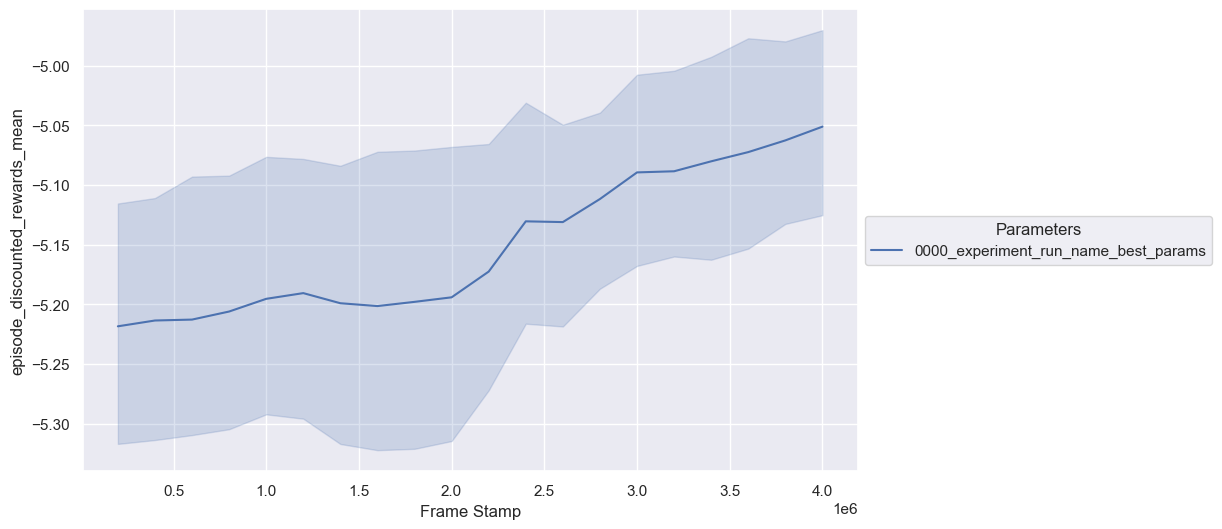

In [146]:

selected_metric = 'episode_discounted_rewards_mean'
# hue_col = "sub_exp_cfg_agent_params.args_.action_w_noise_amplitude"
hue_col = "experiment_name"

validation_df = df[df['epoch_type'] == 'validation']


# Create a new figure for each environment
plt.figure(figsize=(10, 6))
# sns.lineplot(data=df, x='frame_stamp', y=selected_metric, hue='model')
sns.lineplot(data=validation_df, x='frame_stamp', y=selected_metric, hue=hue_col)

plt.ylabel(selected_metric)
plt.xlabel('Frame Stamp')

# Place the legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title='Parameters')
plt.show()

In [147]:
df.columns

Index(['epoch_type', 'frame_stamp', 'greedy_epsilon', 'episode_rewards_min',
       'episode_rewards_max', 'episode_rewards_mean', 'episode_rewards_median',
       'episode_rewards_std', 'episode_discounted_rewards_min',
       'episode_discounted_rewards_max', 'episode_discounted_rewards_mean',
       'episode_discounted_rewards_median', 'episode_discounted_rewards_std',
       'episode_frames_min', 'episode_frames_max', 'episode_frames_mean',
       'episode_frames_median', 'episode_frames_std', 'episode_losses_min',
       'episode_losses_max', 'episode_losses_mean', 'episode_losses_median',
       'episode_losses_std', 'episode_max_qs_min', 'episode_max_qs_max',
       'episode_max_qs_mean', 'episode_max_qs_median', 'episode_max_qs_std',
       'policy_trained_times', 'target_trained_times', 'epoch_time',
       'sub_exp_cfg_experiment_run_name', 'sub_experiment_path', 'seed',
       'experiment_name'],
      dtype='object')

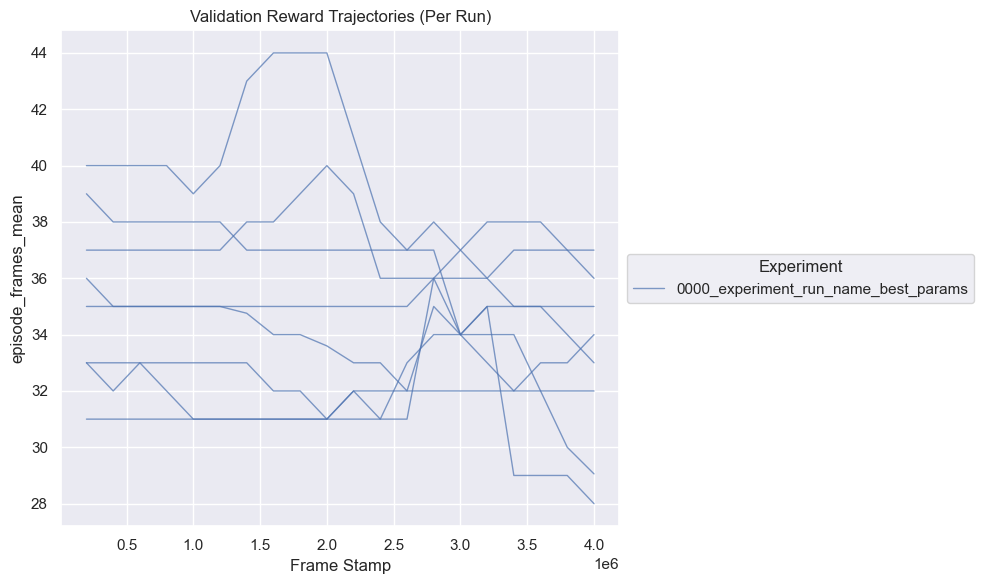

In [148]:
import matplotlib.pyplot as plt
import seaborn as sns

selected_metric = 'episode_frames_mean'
hue_col = "experiment_name"  # or another distinguishing column like "sub_experiment_path"

validation_df = df[df['epoch_type'] == 'validation']

# Plot individual lines for each run
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=validation_df,
    x='frame_stamp',
    y=selected_metric,
    hue=hue_col,
    estimator=None,  # ← disables aggregation
    units='sub_experiment_path',  # ← groups lines by unique run
    lw=1,  # line width
    alpha=0.7  # transparency
)

plt.ylabel(selected_metric)
plt.xlabel('Frame Stamp')
plt.title('Validation Reward Trajectories (Per Run)')

# Move legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title='Experiment')
plt.tight_layout()
plt.show()


In [149]:
### Select data

experiment_columns = [
    'epoch_type', 'frame_stamp',
    'episode_rewards_mean', 'episode_frames_mean', 
    'episode_discounted_rewards_mean',
    'policy_trained_times', 'target_trained_times', 'epoch_time', 
       'seed', 'experiment_name', "sub_experiment_path"
]
hyperparam_columns = [
   col for col in df.columns if "sub_exp_cfg" in col
]

cols_of_interest = experiment_columns + hyperparam_columns

sub_df = df[cols_of_interest]
sub_df = sub_df[sub_df['epoch_type'] == 'validation']
sub_df = sub_df[sub_df['frame_stamp'] == sub_df['frame_stamp'].max()]

sub_df 


,epoch_type,frame_stamp,episode_rewards_mean,episode_frames_mean,episode_discounted_rewards_mean,policy_trained_times,target_trained_times,epoch_time,seed,experiment_name,sub_experiment_path,sub_exp_cfg_experiment_run_name
39,validation,4000000,-10.192105,34.000000,-5.034562,NaN,NaN,0 days 00:00:01.097647,0,0000_experiment_run_name_best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,best_params
79,validation,4000000,-10.735380,36.000000,-5.125709,NaN,NaN,0 days 00:00:01.067336,1,0000_experiment_run_name_best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,best_params
119,validation,4000000,-10.251858,33.000000,-5.151374,NaN,NaN,0 days 00:00:01.133645,2,0000_experiment_run_name_best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,best_params
159,validation,4000000,-9.698152,32.000000,-4.969459,NaN,NaN,0 days 00:00:01.081646,3,0000_experiment_run_name_best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,best_params
199,validation,4000000,-8.779425,28.000000,-4.818712,NaN,NaN,0 days 00:00:00.543693,4,0000_experiment_run_name_best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,best_params
239,validation,4000000,-10.567882,35.000000,-5.116850,NaN,NaN,0 days 00:00:00.492740,5,0000_experiment_run_name_best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,best_params
279,validation,4000000,-9.351224,29.057143,-4.989873,NaN,NaN,0 days 00:00:00.512429,6,0000_experiment_run_name_best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,best_params
319,validation,4000000,-11.112679,37.000000,-5.203189,NaN,NaN,0 days 00:00:00.488535,7,0000_experiment_run_name_best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,best_params


In [150]:
# agg_cols = [col for col in sub_df.columns if "sub_exp_cfg_agent_params" in col]
# aggregated_df = (
#     sub_df.groupby(agg_cols)
#     .agg(episode_discounted_rewards_mean=("episode_discounted_rewards_mean", "mean"))
#     .reset_index()
# )
# aggregated_df

In [151]:
sub_df.columns

Index(['epoch_type', 'frame_stamp', 'episode_rewards_mean',
       'episode_frames_mean', 'episode_discounted_rewards_mean',
       'policy_trained_times', 'target_trained_times', 'epoch_time', 'seed',
       'experiment_name', 'sub_experiment_path',
       'sub_exp_cfg_experiment_run_name'],
      dtype='object')

In [ ]:
# sub_df[[
#     "episode_discounted_rewards_mean", "episode_frames_mean",
#     "seed", "sub_exp_cfg_agent_params.args_.action_w_noise_amplitude"]
# ]

KeyError: "['sub_exp_cfg_agent_params.args_.action_w_noise_amplitude'] not in index"

In [ ]:
# sub_df[
#     (sub_df["sub_exp_cfg_agent_params.args_.action_w_noise_amplitude"] == "0.3") 
# ]

In [153]:
# Print the experiment_name of the row with the highest episode_rewards_mean 
print(sub_df[sub_df['episode_rewards_mean'] == sub_df['episode_rewards_mean'].max()]['sub_experiment_path'].values[0])
# print(sub_df[sub_df['episode_rewards_mean'] == sub_df['episode_rewards_mean'].max()]['experiment_name'].values[0])
# print(sub_df[sub_df['episode_rewards_mean'] == sub_df['episode_rewards_mean'].max()]['episode_rewards_mean'].values[0])


D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dynamics\experiments\results\2025May09-234645_configs\0000_experiment_run_name_best_params\4


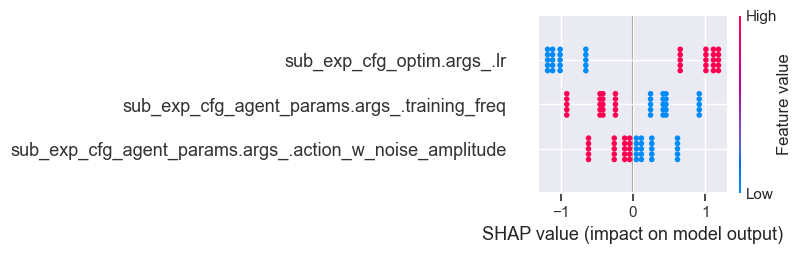

In [ ]:
import shap
import xgboost
import pandas as pd


# Define the target metric and hyperparameter columns
target_metric = "episode_rewards_mean"  # Replace with actual metric column name
# Replace with actual hyperparameter column names

# Prepare data
X = sub_df[hyperparam_columns].apply(pd.to_numeric, errors='coerce')
y = sub_df[target_metric].fillna(3 * sub_df[target_metric].min())

# Train an XGBoost model to analyze feature importance
model = xgboost.XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)
model.fit(X, y)

# SHAP analysis
explainer = shap.Explainer(model)
shap_values = explainer(X)

# Summary plot (feature importance)
shap.summary_plot(shap_values, X)

In [ ]:
hyperparam_columns

['sub_exp_cfg_optim.args_.lr',
 'sub_exp_cfg_agent_params.args_.training_freq',
 'sub_exp_cfg_agent_params.args_.action_w_noise_amplitude']

In [ ]:
import plotly.express as px

# Define readable names for selected hyperparams
readable_names = {
    hyperparam_columns[0]: "noise",
    hyperparam_columns[1]: "size"
}

# Rename columns in a copy of the dataframe
plot_df = sub_df.rename(columns=readable_names)

# Assign new column names
x_col = "noise"
y_col = "episode_rewards_mean"
facet_col = "size"

# Plot
fig = px.scatter(
    plot_df,
    x=x_col,
    y=y_col,
    color="experiment_name",  # Optional: color by experiment
    facet_col=facet_col,
    title="Episode Rewards vs. Noise Faceted by Size",
    height=600
)

fig.update_layout(showlegend=False)
fig.show()
